In [1]:
import pickle as pkl
import os
import sys
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


labels = pd.read_csv('../../MIMIC-CXR-JPG/mimic-cxr-jpg/2.1.0/mimic-cxr-2.0.0-chexpert.csv')

In [2]:
# replace Nans with 0
labels = labels.fillna(0)

In [3]:
labels.head(5)

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,10000032,53189527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,10000032,53911762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,10000032,56699142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,10000764,57375967,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0


In [4]:
with open('../embeddings/autoencoder_2025-04-03-23-05_unbatched.pkl', 'rb') as f:
    embeddings = pkl.load(f)
embeddings = pd.DataFrame(embeddings)

In [5]:
# do a join with labels on subject, study
embeddings['subject'] = embeddings['subject'].astype(str)
labels['subject_id'] = labels['subject_id'].astype(str)
embeddings['study'] = embeddings['study'].astype(str)
labels['study_id'] = labels['study_id'].astype(str)
# embeddings subject is prepended with 'p' and study is prepended with 's' remove first character
embeddings['subject'] = embeddings['subject'].str[1:]
embeddings['study'] = embeddings['study'].str[1:]

embeddings['subject_study'] = embeddings['subject'] + '_' + embeddings['study']
labels['subject_study'] = labels['subject_id'] + '_' + labels['study_id']

merged = pd.merge(embeddings, labels, left_on='subject_study', right_on='subject_study', how='inner')

In [6]:
merged.head()

,partition,subject,study,dicom,embedding,subject_study,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,p10,10039708,58565615,82097a0a-9fcc5d4c-f8120492-7d586391-436af709,"[3.3483272, 6.4395976, 23.655487, 3.8691216, -...",10039708_58565615,10039708,58565615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,p10,10385501,51530878,4fc915ed-e9074958-8fec33fe-fe93d766-652a8df7,"[-7.1300483, 14.521305, 7.8851323, -2.708485, ...",10385501_51530878,10385501,51530878,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,p10,10901462,53175828,df1ae55e-fde680e8-3eea833b-152d2e3a-d6f35076,"[-3.7017326, 3.9614172, 12.087458, -9.686349, ...",10901462_53175828,10901462,53175828,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,p10,10773964,54301540,f9b937e2-3e6749fe-221ca297-ad6a0706-f78e05da,"[11.8429575, -1.6189513, 26.139036, -0.1250332...",10773964_54301540,10773964,54301540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0
4,p10,10917546,59743671,fc5b053d-fdbbca9d-11e328a8-9a43948f-ba87ea96,"[-11.249843, 5.2871757, 15.189109, -5.015622, ...",10917546_59743671,10917546,59743671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [7]:
y_columns = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
             'Fracture', 'Lung Lesion', 'Lung Opacity', 'Pleural Effusion', 'Pleural Other',
             'Pneumonia', 'Pneumothorax', 'Support Devices']
y = merged[y_columns].values
y = np.where(y > 0, 1, 0)

X = merged[['embedding']].values
X = np.array([x[0] for x in X])

In [8]:
# split into train and test


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# check the shape of the data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11246, 128)
(2812, 128)
(11246, 13)
(2812, 13)


Training model for Atelectasis
AUC score for Atelectasis: 0.64
Accuracy for Atelectasis: 0.73


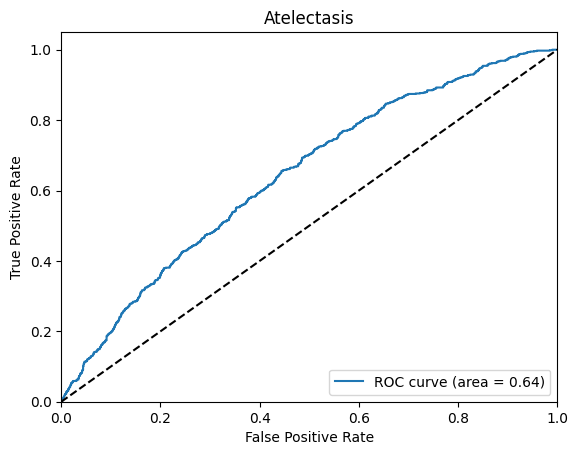

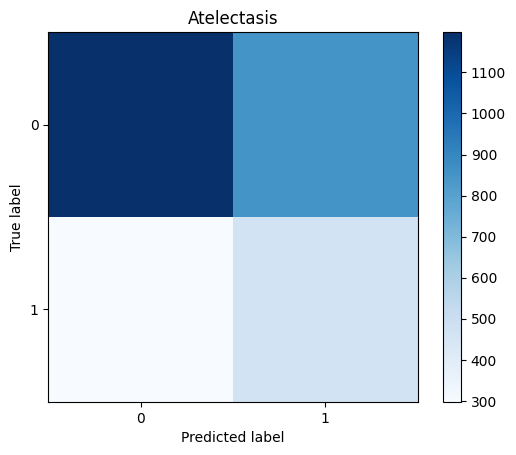

Training model for Cardiomegaly
AUC score for Cardiomegaly: 0.68
Accuracy for Cardiomegaly: 0.73


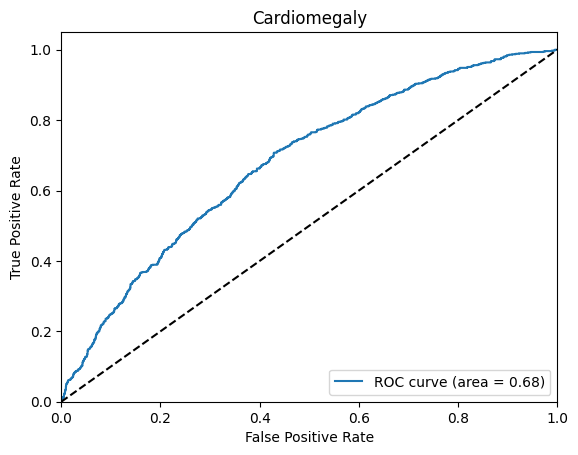

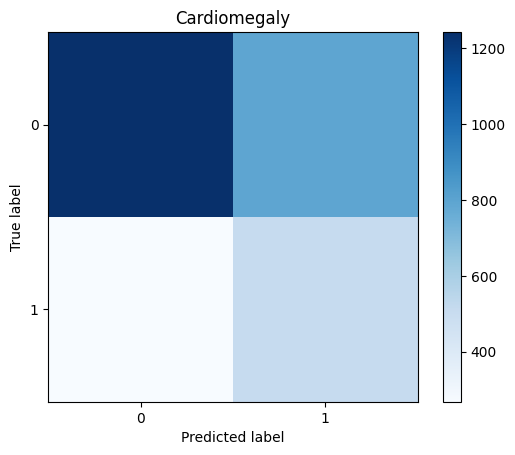

Training model for Consolidation
AUC score for Consolidation: 0.65
Accuracy for Consolidation: 0.92


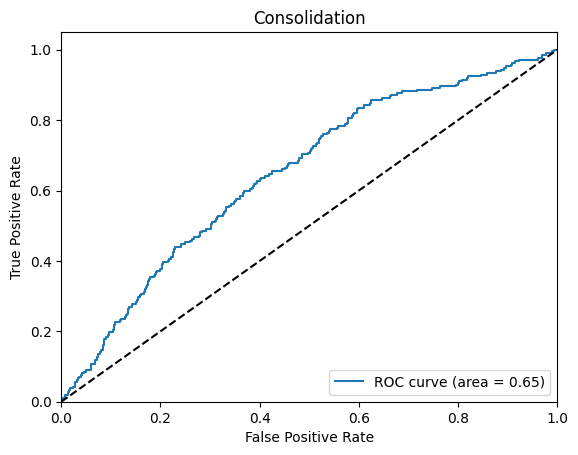

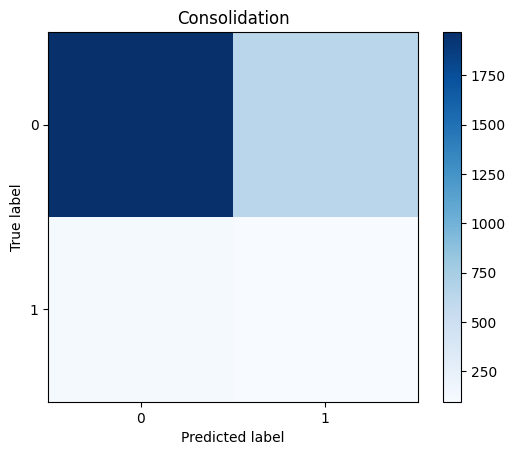

Training model for Edema
AUC score for Edema: 0.73
Accuracy for Edema: 0.82


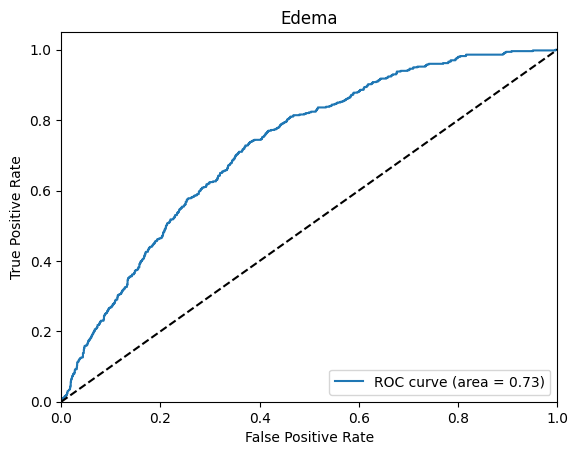

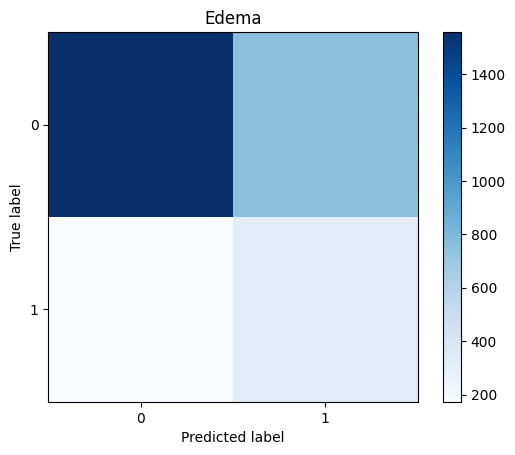

Training model for Enlarged Cardiomediastinum
AUC score for Enlarged Cardiomediastinum: 0.58
Accuracy for Enlarged Cardiomediastinum: 0.96


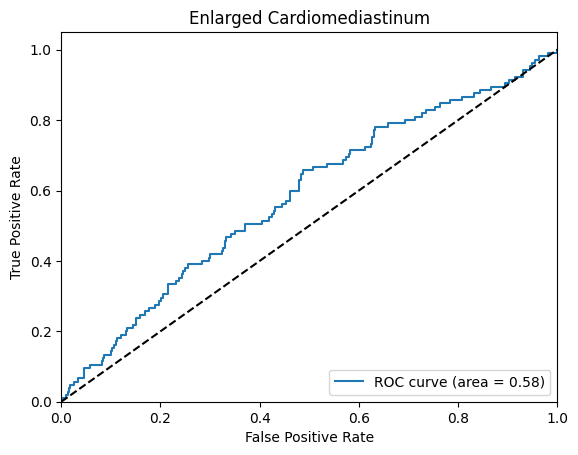

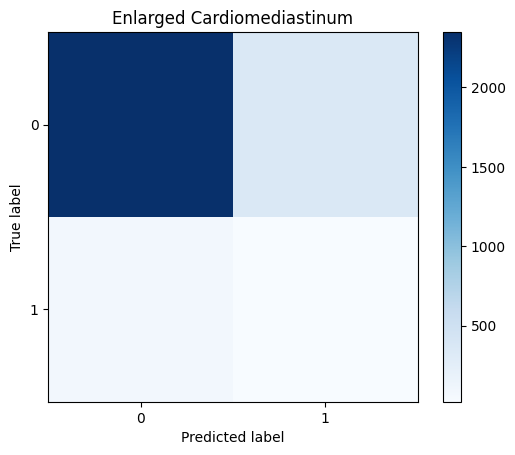

Training model for Fracture
AUC score for Fracture: 0.62
Accuracy for Fracture: 0.98


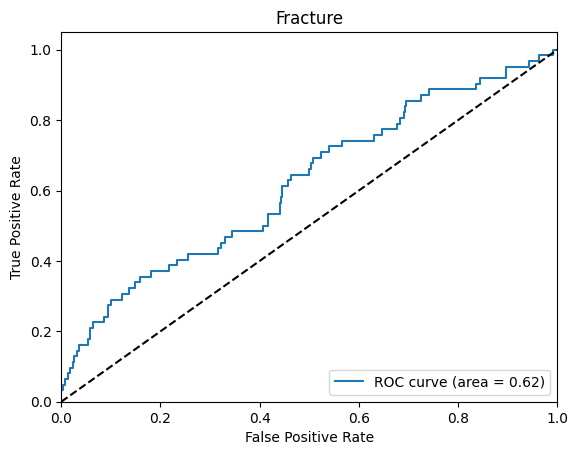

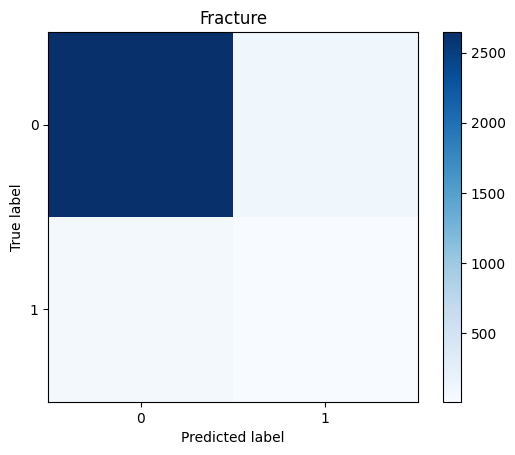

Training model for Lung Lesion
AUC score for Lung Lesion: 0.61
Accuracy for Lung Lesion: 0.97


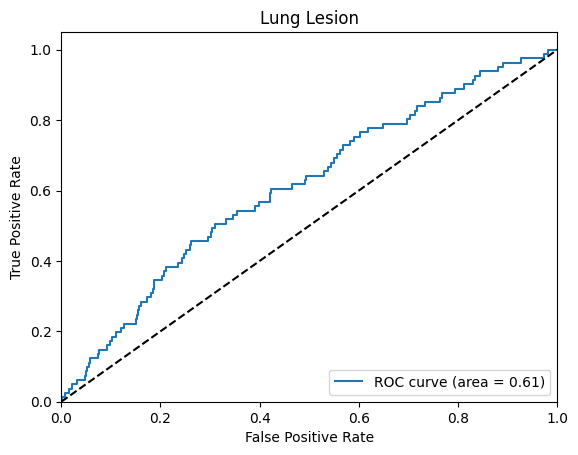

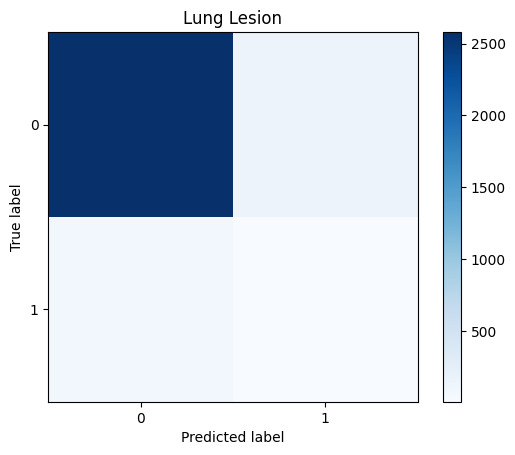

Training model for Lung Opacity
AUC score for Lung Opacity: 0.61
Accuracy for Lung Opacity: 0.73


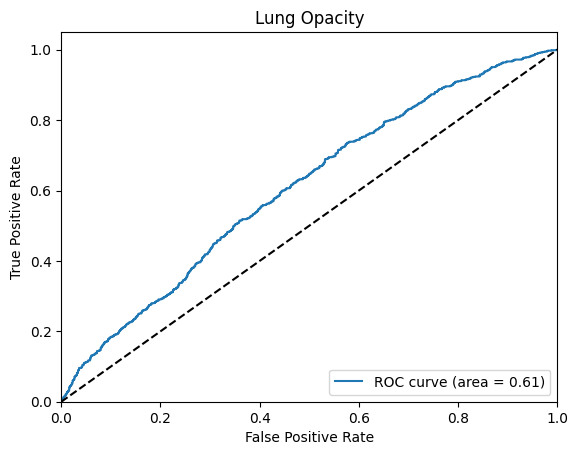

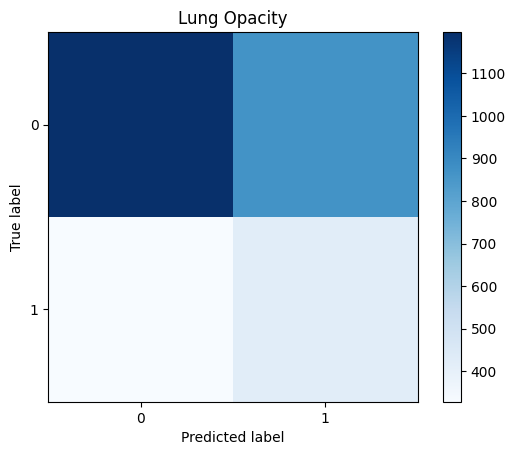

Training model for Pleural Effusion
AUC score for Pleural Effusion: 0.74
Accuracy for Pleural Effusion: 0.71


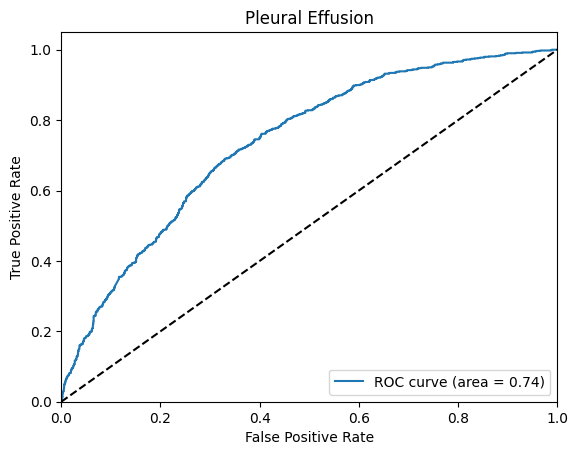

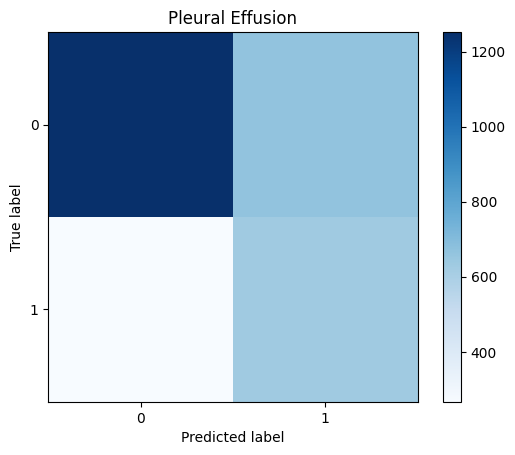

Training model for Pleural Other
AUC score for Pleural Other: 0.56
Accuracy for Pleural Other: 1.00


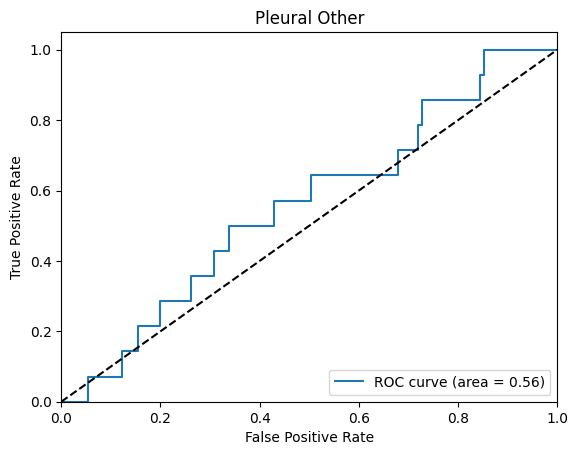

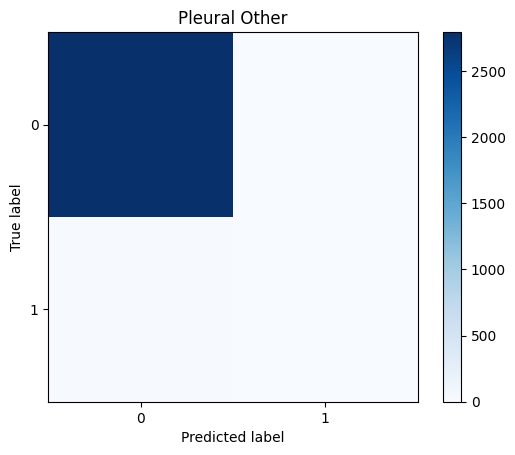

Training model for Pneumonia
AUC score for Pneumonia: 0.57
Accuracy for Pneumonia: 0.92


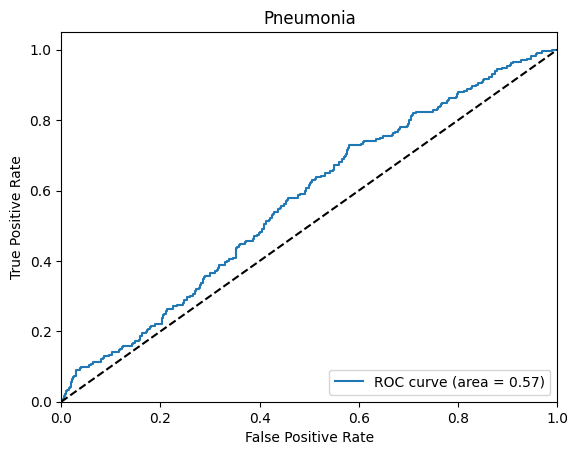

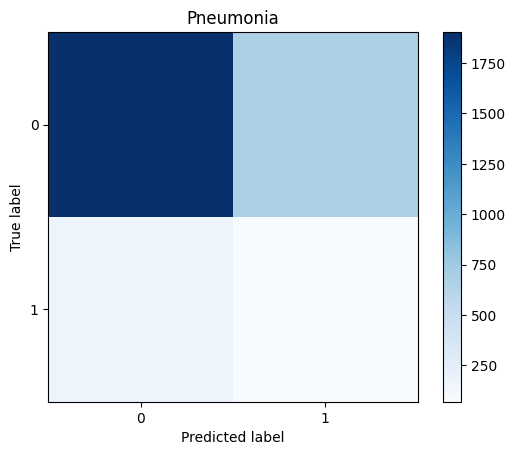

Training model for Pneumothorax
AUC score for Pneumothorax: 0.64
Accuracy for Pneumothorax: 0.94


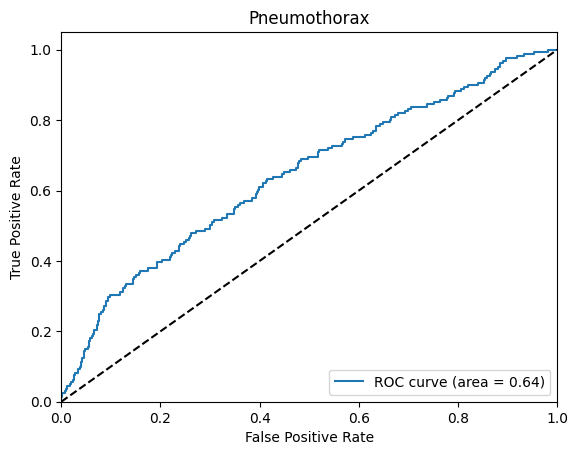

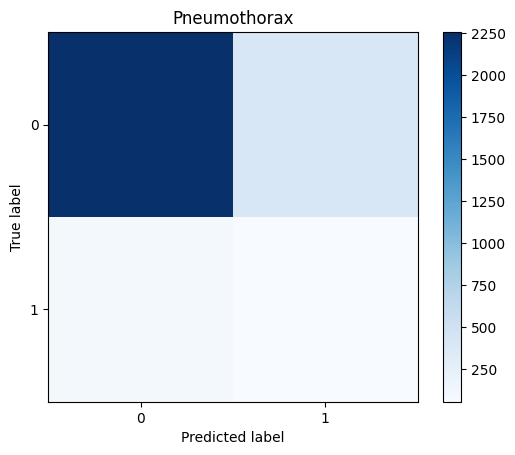

Training model for Support Devices
AUC score for Support Devices: 0.71
Accuracy for Support Devices: 0.66


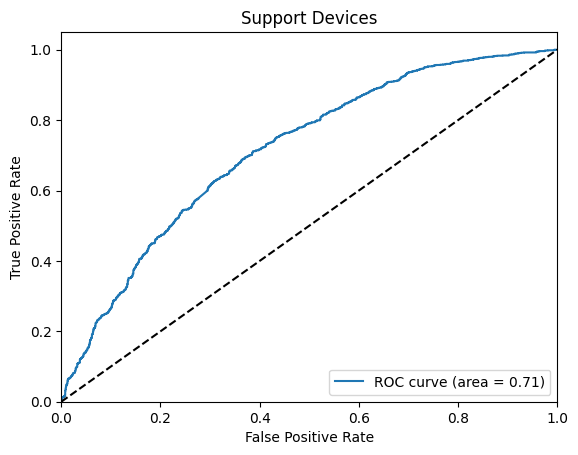

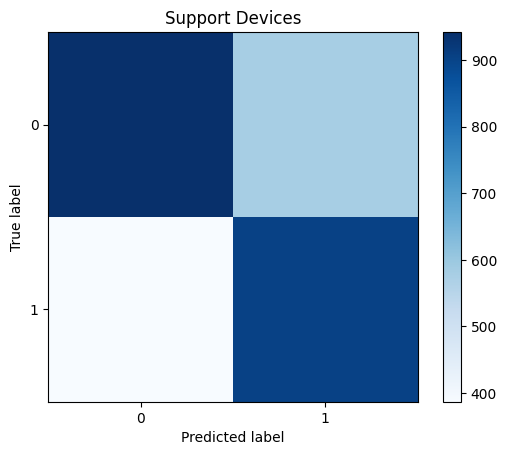

In [10]:
# train a svm classifier for each label
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_roc_curve(y_test, y_pred, label):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    acc = accuracy_score(y_test, y_pred > 0.5)
    print('Accuracy for {}: {:.2f}'.format(label, acc))
    plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(label)
    plt.legend(loc='lower right')
    plt.show()
def plot_confusion_matrix(y_test, y_pred, label):
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(label)
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, np.unique(y_test))
    plt.yticks(tick_marks, np.unique(y_test))
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
def train_model(X_train, y_train, X_test, y_test, label):
    model = SVC(kernel='rbf', class_weight='balanced', probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    y_pred_binary = model.predict(X_test)
    auc_score = roc_auc_score(y_test, y_pred)
    print('AUC score for {}: {:.2f}'.format(label, auc_score))
    plot_roc_curve(y_test, y_pred, label)
    plot_confusion_matrix(y_test, y_pred_binary, label)
    return model

# train a model for each label
models = {}
for i, label in enumerate(y_columns):
    try:
        print('Training model for {}'.format(label))
        y_train_label = y_train[:, i]
        y_test_label = y_test[:, i]
        model = train_model(X_train, y_train_label, X_test, y_test_label, label)
        models[label] = model
    except:
        print('Error training model for {}'.format(label))
        continue